In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Models:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
# Python utilities:
import time
import os

In [2]:
df = pd.read_csv('cs-training.csv')
list(df)

['Unnamed: 0',
 'SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

## Data Cleaning/Preprocessing and EDA

In [3]:
df.drop('Unnamed: 0', axis =1, inplace = True)

In [4]:
df.SeriousDlqin2yrs.mean()

0.06684

If you're over 55 and need a mortgage, the important thing to know is that lenders can't deny you a loan based on your age. But age can factor into your mortgage equation. In order to solve this, we need to confirm that in our data set age has a negative influence on probability of defaulting. Then we can assume that the models we build reflect that trend, and won't deny someone a loan simply because they are old.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'SeriousDlqin2yrs = 1')

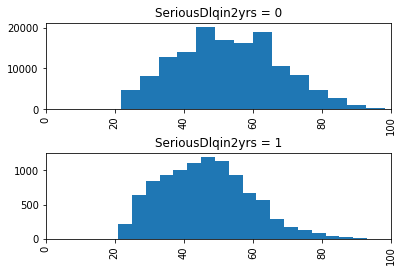

In [6]:
age_hist = df['age'].hist(by=df['SeriousDlqin2yrs'], bins=20, layout=(2,1))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

Looking at the distribution of people that defaulted vs those who did not shows us that, generally, younger people were more responsible for defaulting.

In [7]:
df.DebtRatio.describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

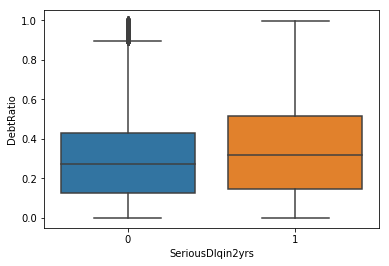

In [8]:
sns.boxplot(df[df['DebtRatio']<1]['SeriousDlqin2yrs'],df[df['DebtRatio']<1]['DebtRatio'])

In [9]:
df[(df['DebtRatio']>1) & (df['SeriousDlqin2yrs']==1)]['DebtRatio'].mean()

1290.3498378125657

In [10]:
df[(df['DebtRatio']>1) & (df['SeriousDlqin2yrs']==0)]['DebtRatio'].mean()

1521.0303812536836

In [11]:
df.DebtRatio.quantile([.975])

0.975    3489.025
Name: DebtRatio, dtype: float64

In [12]:
df[df['DebtRatio'] > 3489.025][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,3750.000000,185.000000
mean,0.064267,0.064865
std,0.245260,0.246956
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [13]:
df[df['DebtRatio'] > 3489.025]['MonthlyIncome'].unique()

array([nan,  0.,  1.])

We see two particularly concerning things here. The first is that of 4,000 records with DebtRatio > 3,500, only 185 of them have a value for monthly income. Further, the people who do have monthly income seem to either have a monthly income of either 1 or 0. 

In [14]:
df[(df['DebtRatio'] > 3489.025) & (df['SeriousDlqin2yrs'] == df['MonthlyIncome'])].shape[0]

164

The filled entries are hence, data-entry errors. The second problem is that despite owing thousands of times what they own, these people aren't defaulting any more than the general population. We can conclude that these entries must be data-entry errors, so we will remove them from our model.

In [15]:
df.groupby('NumberOfTimes90DaysLate').count().head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
NumberOfTimes90DaysLate,,,,,,,,,,
0,141662,141662,141662,141662,141662,113544,141662,141662,141662,137922
1,5243,5243,5243,5243,5243,4312,5243,5243,5243,5141
2,1555,1555,1555,1555,1555,1234,1555,1555,1555,1522
3,667,667,667,667,667,543,667,667,667,656
4,291,291,291,291,291,241,291,291,291,289


In [16]:
df.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()

NumberOfTimes90DaysLate
0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [17]:
df[df['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,269.000000,269.000000,269.000000,269.000000
mean,0.546468,97.962825,97.962825,97.962825
std,0.498764,0.270628,0.270628,0.270628
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


Somehow, all these (300) people were 30-59 days late 96/98 times, 60-89 days late 96/98 times, and 90+ days late 96/98 times. However, the data might not be garbage, because (as expected) these people are defaulting at a massive rate (55%) compared to the population (6%).

In [18]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > .9) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 4)].SeriousDlqin2yrs.describe()

count    19805.000000
mean         0.225347
std          0.417821
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64

These 20,000 people are defaulting at a rate of almost 1-in-4. This is important! But what about people with more RUUL? Let's consider 4 to 10:

In [19]:
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 4) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 10)].SeriousDlqin2yrs.describe()

count    23.000000
mean      0.260870
std       0.448978
min       0.000000
25%       0.000000
50%       0.000000
75%       0.500000
max       1.000000
Name: SeriousDlqin2yrs, dtype: float64

In [20]:
df[df['RevolvingUtilizationOfUnsecuredLines'] > 10].SeriousDlqin2yrs.describe()

count    241.000000
mean       0.070539
std        0.256587
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: SeriousDlqin2yrs, dtype: float64

These 241 people are not defaulting any more than anyone else, despite some of them owing hundreds of thousands of times their credit limits. These seem to be inconsistent with the rest of the data, so we can remove them from our model.

In [21]:
df1 = df[df['MonthlyIncome']>1] 

In [22]:
np.log(df1['MonthlyIncome']).describe()

count    118030.000000
mean          8.566796
std           0.708674
min           0.693147
25%           8.160518
50%           8.608495
75%           9.027979
max          14.917035
Name: MonthlyIncome, dtype: float64

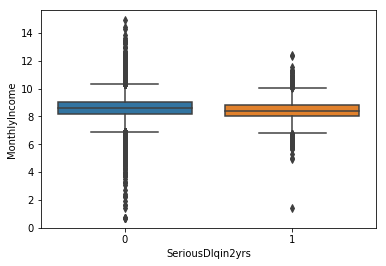

In [23]:
sns.boxplot(df1['SeriousDlqin2yrs'],np.log(df1['MonthlyIncome']))

In [ ]:
not_missing = df.dropna()
target = 'MonthlyIncome'
predictors = [c for c in list(not_missing) if c not in [target, 'Unnamed: 0','SeriousDlqin2yrs']]
X_data = not_missing[predictors]
y_data = not_missing[target]
regr = LinearRegression().fit(X_data, y_data)

In [ ]:
regr.score(X_data, y_data)

0.022015056325770832

This is a terrible  R2 . It seems that our best bet is to just replace the missing values with the median (instead of the mean, because there are some extreme outliers in MonthlyIncome, who are making millions of dollars a month).

In [ ]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [ ]:
# Median Fill, Outliers Removed
removed_debt_outliers = df.drop(df[df['DebtRatio'] > 3489.025].index)
removed_debt_outliers = removed_debt_outliers.fillna(removed_debt_outliers.median())

In [ ]:
# Removed utilization outliers
dfus = removed_debt_outliers.drop(removed_debt_outliers[removed_debt_outliers['RevolvingUtilizationOfUnsecuredLines'] > 10].index)

In [ ]:
# Removed 98s
dfn98 = dfus.copy()
dfn98.loc[dfn98['NumberOfTime30-59DaysPastDueNotWorse'] > 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 18
dfn98.loc[dfn98['NumberOfTime60-89DaysPastDueNotWorse'] > 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 18
dfn98.loc[dfn98['NumberOfTimes90DaysLate'] > 90, 'NumberOfTimes90DaysLate'] = 18

In [ ]:
dfn98.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Model Building and Training

In [ ]:
# A utility class to test all of our models on different datasets
class Tester():
    def __init__(self, target):
        self.target = target
        self.datasets = {}
        self.models = {}
        self.cache = {} # we added a simple cache to speed things up

    def addDataset(self, name, df):
        self.datasets[name] = df.copy()

    def addModel(self, name, model):
        self.models[name] = model
        
    def clearModels(self):
        self.models = {}

    def clearCache(self):
        self.cache = {}
    
    def testModelWithDataset(self, m_name, df_name, sample_len, cv):
        if (m_name, df_name, sample_len, cv) in self.cache:
            return self.cache[(m_name, df_name, sample_len, cv)]

        clf = self.models[m_name]
        
        #if not sample_len: 
        #    sample = self.datasets[df_name]
        #else: sample = self.datasets[df_name].sample(sample_len)
        
        sample = self.datasets[df_name]
            
        X = sample.drop([self.target], axis=1)
        Y = sample[self.target]

        s = cross_validate(clf, X, Y, scoring=['roc_auc'], cv=cv, n_jobs=-1)
        self.cache[(m_name, df_name, sample_len, cv)] = s

        return s

    def runTests(self, sample_len=80000, cv=4):
        # Tests the added models on all the added datasets
        scores = {}
        for m_name in self.models:
            for df_name in self.datasets:
                # print('Testing %s' % str((m_name, df_name)), end='')
                start = time.time()

                score = self.testModelWithDataset(m_name, df_name, sample_len, cv)
                scores[(m_name, df_name)] = score
                
                end = time.time()
                
                # print(' -- %0.2fs ' % (end - start))

        print('--- Top 10 Results ---')
        for score in sorted(scores.items(), key=lambda x: -1 * x[1]['test_roc_auc'].mean())[:10]:
            auc = score[1]['test_roc_auc']
            print("%s --> AUC: %0.4f (+/- %0.4f)" % (str(score[0]), auc.mean(), auc.std()))

            
# We will use a tester object across all models
tester = Tester('SeriousDlqin2yrs')

# You can add datasets like this:
tester.addDataset('Drop Missing', df.dropna())

# And models like this:
rfc = RandomForestClassifier(n_estimators=15, max_depth = 6, random_state=0)
tester.addModel('Simple Random Forest', rfc)
tester.addModel('Simple SVM', svm.LinearSVC())

# You can then use it to run the tests
tester.runTests()

--- Top 10 Results ---
('Simple Random Forest', 'Drop Missing') --> AUC: 0.8485 (+/- 0.0025)
('Simple SVM', 'Drop Missing') --> AUC: 0.5324 (+/- 0.0593)


In [ ]:
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)

tester.runTests()

--- Top 10 Results ---
('Simple Random Forest', 'Removed utilization outliers') --> AUC: 0.8601 (+/- 0.0020)
('Simple Random Forest', 'Removed 98s') --> AUC: 0.8601 (+/- 0.0020)
('Simple Random Forest', 'Median Fill, Outliers Removed') --> AUC: 0.8596 (+/- 0.0015)
('Simple Random Forest', 'Median Fill') --> AUC: 0.8586 (+/- 0.0022)
('Simple Random Forest', 'Drop Missing') --> AUC: 0.8485 (+/- 0.0025)
('Simple SVM', 'Removed 98s') --> AUC: 0.6387 (+/- 0.0459)
('Simple SVM', 'Removed utilization outliers') --> AUC: 0.6022 (+/- 0.0815)
('Simple SVM', 'Median Fill') --> AUC: 0.5831 (+/- 0.0293)
('Simple SVM', 'Median Fill, Outliers Removed') --> AUC: 0.5726 (+/- 0.0366)
('Simple SVM', 'Drop Missing') --> AUC: 0.5324 (+/- 0.0593)


In [ ]:
# A utility class to test all of our models on different datasets
class Tester():
    def __init__(self, target):
        self.target = target
        self.datasets = {}
        self.models = {}
        self.cache = {} # we added a simple cache to speed things up

    def addDataset(self, name, df):
        self.datasets[name] = df.copy()

    def addModel(self, name, model):
        self.models[name] = model
        
    def clearModels(self):
        self.models = {}

    def clearCache(self):
        self.cache = {}
    
    def testModelWithDataset(self, m_name, df_name, sample_len, cv):
        if (m_name, df_name, sample_len, cv) in self.cache:
            return self.cache[(m_name, df_name, sample_len, cv)]

        clf = self.models[m_name]
        
        if not sample_len: 
            sample = self.datasets[df_name]
        else: sample = self.datasets[df_name].sample(sample_len)
            
        X = sample.drop([self.target], axis=1)
        Y = sample[self.target]

        s = cross_validate(clf, X, Y, scoring=['roc_auc'], cv=cv, n_jobs=-1)
        self.cache[(m_name, df_name, sample_len, cv)] = s

        return s,sample

    def runTests(self, sample_len=80000, cv=4, thresh=0.5):
        # Tests the added models on all the added datasets
        scores = {}
        for m_name in self.models:
            for df_name in self.datasets:
                # print('Testing %s' % str((m_name, df_name)), end='')
                start = time.time()

                score,sample = self.testModelWithDataset(m_name, df_name, sample_len, cv)
                scores[(m_name, df_name)] = score
                
                end = time.time()
                
                # print(' -- %0.2fs ' % (end - start))
        
        m_df_name = []
        
        print('--- Top 10 Results ---')
        for score in sorted(scores.items(), key=lambda x: -1 * x[1]['test_roc_auc'].mean())[:10]:
            auc = score[1]['test_roc_auc']
            print("%s --> AUC: %0.4f (+/- %0.4f)" % (str(score[0]), auc.mean(), auc.std()))
            m_df_name.append(score[0])
            
        c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold= self.predTest(m_df_name[0], sample, thresh)
            
        return c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold
            
    def predTest(self, scores, sample, thresh):
        
        m_name,df_name = scores
        
        X_train = sample.drop([self.target], axis=1)
        Y_train = sample[self.target]
        
        clf = self.models[m_name]
        clf.fit(X_train, Y_train)
        
        data = self.datasets[df_name]
        #actual data

        data.drop(sample.index,inplace=True)
        
        X_test = data.drop([self.target], axis=1)
        Y_test = data[self.target]
        
        predict = clf.predict_proba(X_test)
        predict = predict[:,1]
        
        fpr, tpr, threshold=roc_curve(Y_test,predict)
        
        recall_scores = 0
        cmatrix = {}

        for thres in np.linspace(0.15, 0.5, 40):
            
            predicted = (predict>thres).astype(int)
            cmatrix[thres] = confusion_matrix(Y_test, predicted)
            recall = recall_score(Y_test, predicted)
            if recall > recall_scores:
                recall_scores = recall
                thresh = thres
                
        
        predicted = (predict>thresh).astype(int)
        
        c_matrix = confusion_matrix(Y_test, predicted)
        f1_scores = f1_score(Y_test, predicted)
        accuracy= accuracy_score(Y_test, predicted)
        
        predict_train = clf.predict_proba(X_train)
        predict_train = predict_train[:,1]
        predicted_train = (predict_train>thresh).astype(int)
        
        c_matrix_train = confusion_matrix(Y_train, predicted_train)
        f1_scores_train = f1_score(Y_train, predicted_train)
        accuracy_train= accuracy_score(Y_train, predicted_train)
        
        return c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold
    
    # We will use a tester object across all models
tester = Tester('SeriousDlqin2yrs')

# You can add datasets like this:
tester.addDataset('Drop Missing', df.dropna())

# And models like this:
rfc = RandomForestClassifier(n_estimators=15, max_depth = 6, random_state=0)
tester.addModel('Simple Random Forest', rfc)
tester.addModel('Simple SVM', svm.LinearSVC())

# You can then use it to run the tests
c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold=tester.runTests()

--- Top 10 Results ---
('Simple Random Forest', 'Drop Missing') --> AUC: 0.8481 (+/- 0.0053)
('Simple SVM', 'Drop Missing') --> AUC: 0.5114 (+/- 0.0351)


In [ ]:
c_matrix

array([[34485,  2984],
       [ 1253,  1547]], dtype=int64)

In [ ]:
# A utility class to test all of our models on different datasets
class Tester1():
    def __init__(self, target):
        self.target = target
        self.datasets = {}
        self.models = {}
        self.cache = {} # we added a simple cache to speed things up

    def addDataset(self, name, df):
        self.datasets[name] = df.copy()

    def addModel(self, name, model):
        self.models[name] = model
        
    def clearModels(self):
        self.models = {}

    def clearCache(self):
        self.cache = {}
    
    def testModelWithDataset(self, m_name, df_name, sample_len, cv):
        if (m_name, df_name, sample_len, cv) in self.cache:
            return self.cache[(m_name, df_name, sample_len, cv)]

        clf = self.models[m_name]
        
        if not sample_len: 
            sample = self.datasets[df_name]
        else: sample = self.datasets[df_name].sample(sample_len)
            
        X = sample.drop([self.target], axis=1)
        Y = sample[self.target]

        s = cross_validate(clf, X, Y, scoring=['roc_auc'], cv=cv, n_jobs=-1)
        self.cache[(m_name, df_name, sample_len, cv)] = s

        return s,sample

    def runTests(self, sample_len=80000, cv=4, thresh=0.5):
        # Tests the added models on all the added datasets
        scores = {}
        for m_name in self.models:
            for df_name in self.datasets:
                # print('Testing %s' % str((m_name, df_name)), end='')
                start = time.time()

                score,sample = self.testModelWithDataset(m_name, df_name, sample_len, cv)
                scores[(m_name, df_name)] = score
                
                end = time.time()
                
                # print(' -- %0.2fs ' % (end - start))
        
        m_df_name = []
        
        print('--- Top 10 Results ---')
        for score in sorted(scores.items(), key=lambda x: -1 * x[1]['test_roc_auc'].mean())[:10]:
            auc = score[1]['test_roc_auc']
            print("%s --> AUC: %0.4f (+/- %0.4f)" % (str(score[0]), auc.mean(), auc.std()))
            m_df_name.append(score[0])
            
        c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold, imp = self.predTest(m_df_name[0], sample, thresh)
            
        return c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold, imp
            
    def predTest(self, scores, sample, thresh):
        
        m_name,df_name = scores
        
        X_train = sample.drop([self.target], axis=1)
        Y_train = sample[self.target]
        
        clf = self.models[m_name]
        clf.fit(X_train, Y_train)
        
        data = self.datasets[df_name]
        #actual data

        data.drop(sample.index,inplace=True)
        
        X_test = data.drop([self.target], axis=1)
        Y_test = data[self.target]
        
        selected_feat =  X_test.columns
        imp = pd.DataFrame(selected_feat)
        imp['importance'] = clf.feature_importances_
        
        predict = clf.predict_proba(X_test)
        predict = predict[:,1]
        
        fpr, tpr, threshold=roc_curve(Y_test,predict)
        
        recall_scores = 0
        cmatrix = {}

        for thres in np.linspace(0.15, 0.5, 40):
            
            predicted = (predict>thres).astype(int)
            cmatrix[thres] = confusion_matrix(Y_test, predicted)
            recall = recall_score(Y_test, predicted)
            if recall > recall_scores:
                recall_scores = recall
                thresh = thres
                
        
        predicted = (predict>thresh).astype(int)
        
        c_matrix = confusion_matrix(Y_test, predicted)
        f1_scores = f1_score(Y_test, predicted)
        accuracy= accuracy_score(Y_test, predicted)
        
        predict_train = clf.predict_proba(X_train)
        predict_train = predict_train[:,1]
        predicted_train = (predict_train>thresh).astype(int)
        
        c_matrix_train = confusion_matrix(Y_train, predicted_train)
        f1_scores_train = f1_score(Y_train, predicted_train)
        accuracy_train= accuracy_score(Y_train, predicted_train)
        
        return c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold, imp

In [ ]:
tester1 = Tester1('SeriousDlqin2yrs')

In [ ]:
tester1.addDataset('Median Fill', df.fillna(df.median()))
tester1.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester1.addDataset('Removed 98s', dfn98)
tester1.addDataset('Removed utilization outliers', dfus)

rfc = RandomForestClassifier(n_estimators=15, max_depth = 6, random_state=0)
tester1.addModel('Simple Random Forest', rfc)
tester1.addModel('Simple SVM', svm.LinearSVC())

c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold, imp=tester1.runTests()

--- Top 10 Results ---
('Simple Random Forest', 'Median Fill, Outliers Removed') --> AUC: 0.8601 (+/- 0.0033)
('Simple Random Forest', 'Removed 98s') --> AUC: 0.8577 (+/- 0.0014)
('Simple Random Forest', 'Median Fill') --> AUC: 0.8570 (+/- 0.0024)
('Simple Random Forest', 'Removed utilization outliers') --> AUC: 0.8550 (+/- 0.0060)
('Simple SVM', 'Median Fill') --> AUC: 0.5929 (+/- 0.0499)
('Simple SVM', 'Removed utilization outliers') --> AUC: 0.5854 (+/- 0.0396)
('Simple SVM', 'Removed 98s') --> AUC: 0.5498 (+/- 0.0739)
('Simple SVM', 'Median Fill, Outliers Removed') --> AUC: 0.5377 (+/- 0.0386)


In [ ]:
imp1 = imp.sort_values(by= ['importance'], ascending = True)

In [ ]:
imp1

,0,importance
9,NumberOfDependents,0.003945
7,NumberRealEstateLoansOrLines,0.010717
4,MonthlyIncome,0.011042
3,DebtRatio,0.014831
5,NumberOfOpenCreditLinesAndLoans,0.020118
1,age,0.030842
2,NumberOfTime30-59DaysPastDueNotWorse,0.079490
8,NumberOfTime60-89DaysPastDueNotWorse,0.135197
0,RevolvingUtilizationOfUnsecuredLines,0.211097
6,NumberOfTimes90DaysLate,0.482721


<BarContainer object of 10 artists>

<Figure size 576x720 with 0 Axes>

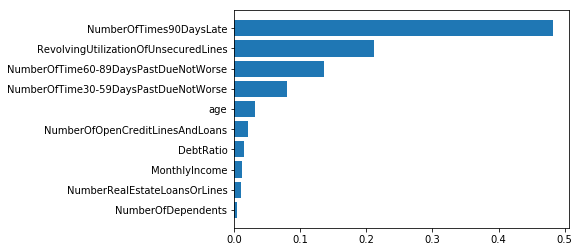

In [ ]:
plt.figure(figsize=(8,10))
fig, ax = plt.subplots()
ax.barh(imp1[0],imp1['importance'])

In [ ]:
cmatrix[0.15]

array([[57457,  4439],
       [ 1964,  2390]], dtype=int64)

In [ ]:
f1_scores

0.4274344987928105

In [ ]:
roc_auc = metrics.auc(fpr, tpr)

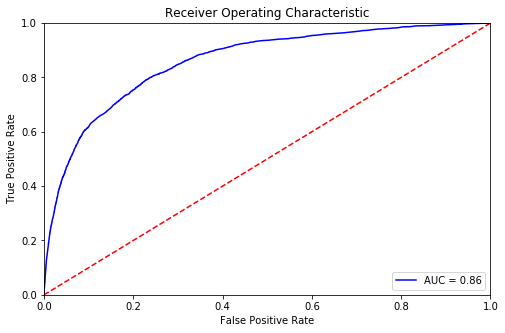

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
fig.savefig("AUC")

In [ ]:
tester1 = Tester1('SeriousDlqin2yrs')
tester1.addDataset('Median Fill', df.fillna(df.median()))
tester1.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester1.addDataset('Removed 98s', dfn98)
tester1.addDataset('Removed utilization outliers', dfus)

In [ ]:
for i in range(5,10):
    for j in range(10,20):
        rfc = RandomForestClassifier(n_estimators=j,max_depth = i, random_state=0)
        tester1.addModel('Random Forest '+'d: '+str(i)+' est: '+str(j)  ,rfc)

c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold, imp=tester1.runTests()

In [ ]:
tester = Tester('SeriousDlqin2yrs')
tester.addDataset('Median Fill', df.fillna(df.median()))
tester.addDataset('Median Fill, Outliers Removed', removed_debt_outliers)
tester.addDataset('Removed 98s', dfn98)
tester.addDataset('Removed utilization outliers', dfus)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(5, 10):
    neigh = KNeighborsClassifier(n_neighbors=i)
    tester.addModel('KNN k=%d' % i, neigh)
    
c_matrix, f1_scores, accuracy, c_matrix_train, f1_scores_train, accuracy_train, thresh, cmatrix, fpr, tpr, threshold=tester.runTests()

## KMeans Clustering to Segregate Defaulters

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
df1 =df.copy()

In [ ]:
df1['MonthlyIncome'].fillna(df1['MonthlyIncome'].median(),inplace=True)

In [ ]:
df1['NumberOfDependents'].fillna(df1['NumberOfDependents'].median(),inplace=True)

In [ ]:
df1.drop('SeriousDlqin2yrs',axis=1,inplace=True)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=0)

In [ ]:
kmeans.fit(df1)

In [ ]:
df['Cluster_label']= kmeans.labels_

In [ ]:
prop = (df[df['Cluster_label']==0]['SeriousDlqin2yrs'].mean(),df[df['Cluster_label']==1]['SeriousDlqin2yrs'].mean(),df[df['Cluster_label']==2]['SeriousDlqin2yrs'].mean(),df[df['Cluster_label']==3]['SeriousDlqin2yrs'].mean(),df[df['Cluster_label']==4]['SeriousDlqin2yrs'].mean(),df[df['Cluster_label']==5]['SeriousDlqin2yrs'].mean())

In [ ]:
length = (len(df[df['Cluster_label']==0]),len(df[df['Cluster_label']==1]),len(df[df['Cluster_label']==2]),len(df[df['Cluster_label']==3]),len(df[df['Cluster_label']==4]),len(df[df['Cluster_label']==5]))

In [ ]:
clus_data = pd.DataFrame({'Proportion_deafult':prop,'Length_cluster':length})

In [ ]:
clus_data #Kmeans clustering is not useful to segregate defaulters